# Import necessary library

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from scipy.stats import skew, norm, zscore
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Explore data

In [3]:
# Read train and test data
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

# Combine train and test data for data cleaning
y = train.SalePrice
train = train.drop("SalePrice", axis=1)

train["train_test"] = 1
test["train_test"] = 0

X = pd.concat([train, test])

# Create categorical columns
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
# Create numeric columns
numerical_cols = train.select_dtypes(exclude=["object"]).columns.tolist()

"""
Split features further: continuous, discrete, ordinal, nominal, alphanumerical and binary

Continuous features: 'LotFrontage', 'LotArea', 'MasVnrArea', '
    BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'GarageArea', 'WoodDeckSF', 
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'

Discrete features: 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'BsmtFullBath', 
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr'

Ordinal features: 'OverallQual', 'OverallCond', 'LotShape', 'ExterQual', 'ExterCond', 
    'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
    'PavedDrive'(Ordinal or nominal?), 'PoolQC', 'Fence'(Ordinal or nominal?)

Nominal features: 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 
    'LandSlope', 'Neighborhood', 'Condition1','Condition2', 'RoofStyle', 'RoofMatl', 
    'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 
    'Functional', 'GarageType', 'MiscFeature', 'SaleType','SaleCondition', 'MSSubClass'

Alphanumerical features: 'LotConfig','BldgType','HouseStyle'

Binary features: CentralAir

Temp features: train_test

N.B. MSSubClass appears to be a discrete features but is infact a nominal one


"""

train["MSSubClass"] = train["MSSubClass"].astype("str")
test["MSSubClass"] = test["MSSubClass"].astype("str")
X["MSSubClass"] = X["MSSubClass"].astype("str")
numerical_cols.remove("MSSubClass")
categorical_cols.append("MSSubClass")

# Continuous: lien tuc
cont_features = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
]

# Discrete: roi rac
disc_features = [
    "MSSubClass",
    "YearBuilt",
    "YearRemodAdd",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "MoSold",
    "YrSold",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
]

# Ordinal:
ord_features = [
    "OverallQual",
    "OverallCond",
    "LotShape",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "PoolQC",
    "Fence",
]

# Nominal
nom_features = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "Electrical",
    "Functional",
    "GarageType",
    "MiscFeature",
    "SaleType",
    "SaleCondition",
]

# Alphanumerical
alpnum_features = ["LotConfig", "BldgType", "HouseStyle"]
# Binary
bin_features = ["CentralAir"]

temp_features = ["train_test"]


In [4]:
test.shape

(1459, 80)

# Data Visualisation

In [5]:
# Import library
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Target Feature

<Axes: xlabel='SalePrice', ylabel='Count'>

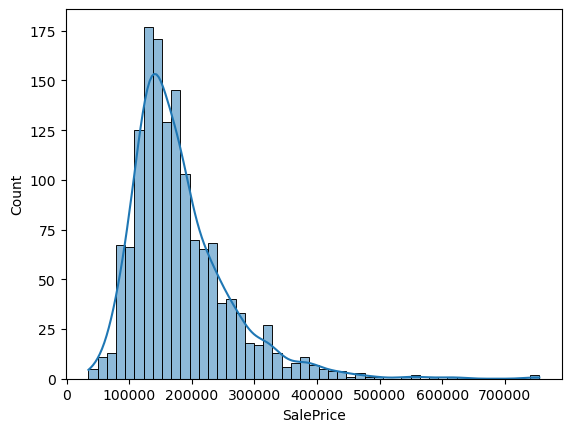

In [6]:
sns.histplot(y, kde = True)

Slight skew in SalePrice to the right, might be worth log(1+x) transforming the target

Look at correlation between target and features

In [7]:
correlation = pd.concat([train[numerical_cols], y], axis = 1).corr()

correlation[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Numerical Features

In [8]:
show = False

In [9]:
def plot_num_hist(show):
    if (show == True):
        fig = plt.figure(figsize=(20, 40))
        ax = []
        for i, val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(10, 4, i+1))
            ax.append(sns.histplot(train[val].dropna(), kde=True))
            fig.tight_layout()
plot_num_hist(show)

Mostly 0 area for some features e.g. Porch and Pools

In [10]:
def plot_num_box(show):
    if (show == True):
        fig = plt.figure(figsize=(20, 40))
        ax = []
        for i, val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(10, 4, i+1))
            ax.append(sns.boxplot(train[val].dropna()))
            fig.tight_layout()
plot_num_box(show)

Most extreme outliers are: 'LotFrontage','LotArea','BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea'

Less extreme outliers are: 'MasVnrArea', '1stFlrSF', 'Fireplaces', 'GarageCars', 'OpenPorchSF'

Mostly 0s: BsmtFinSF2, LowQualFinSF, 'BsmtHalfBalf','KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'

Look for quasi-constant features (features with >95% of the same values here)

In [11]:
overfit_num = []
for col in numerical_cols:
    counts = train[col].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) > 0.95:
        overfit_num.append(col)

overfit_num

['LowQualFinSF',
 'KitchenAbvGr',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'train_test']

Look for multicollinearity of over 80%

In [12]:
def plot_num_corr(show):
    if (show == True):
        plt.figure(figsize=(14, 12))
        sns.heatmap(correlation, mask=correlation<0.8, 
                    linecolor = 'black', linewidths=.5)
plot_num_corr(show)

GarageYrBlt and YearBuilt

1stFlrSF and TotalBsmtSF

GarageArea and GarageCars

TotRmsAbvGrd and GrLivArea

In [13]:
def plot_num_reg(show):
    if (show == True):
        fig = plt.figure(figsize=(20, 40))
        ax = []
        for i, val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(10, 4, i+1))
            ax.append(sns.regplot(x = val, y = 'SalePrice', 
                                  data = pd.concat([train[numerical_cols], y],
                                                   axis = 1).dropna()))
            fig.tight_layout()
plot_num_reg(show)

Features with mostly 0s have poor correlations with SalePrice.

YrSold and MoSold have no correlation with the SalePrice and should be removed.


### Categorical Features

In [14]:
def plot_cat_count(show):
    if show == True:
        fig = plt.figure(figsize=(20, 40))
        ax = []
        
        for i, val in enumerate(categorical_cols):
            ax.append(fig.add_subplot(11, 4, i+1))
            ax.append(sns.countplot(data = train, x = val))
        fig.tight_layout()
plot_cat_count(show)

Highest Cardinality Features: 'Neighborhood', 'Exterior1st', 'Exterior2nd'

In [15]:
overfit_cat = []
for col in categorical_cols:
    counts = train[col].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) > 0.95:
        overfit_cat.append(col)
overfit_cat

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [16]:
def cat_box(show):
    if show == True:
        fig = plt.figure(figsize = (20, 40))
        for i, val in enumerate(categorical_cols):
            sns.catplot(x = val, y = 'SalePrice', data = pd.concat([
                train[categorical_cols], y
            ], axis = 1), kind='box')
            fig.tight_layout()
# cat_box(show)

### NA values

              Features
PoolQC        0.995205
MiscFeature   0.963014
Alley         0.937671
Fence         0.807534
MasVnrType    0.597260
FireplaceQu   0.472603
LotFrontage   0.177397
GarageYrBlt   0.055479
GarageCond    0.055479
GarageType    0.055479
GarageFinish  0.055479
GarageQual    0.055479
BsmtExposure  0.026027
BsmtFinType2  0.026027
BsmtCond      0.025342
BsmtQual      0.025342
BsmtFinType1  0.025342
MasVnrArea    0.005479
Electrical    0.000685


<Axes: xlabel='None', ylabel='Features'>

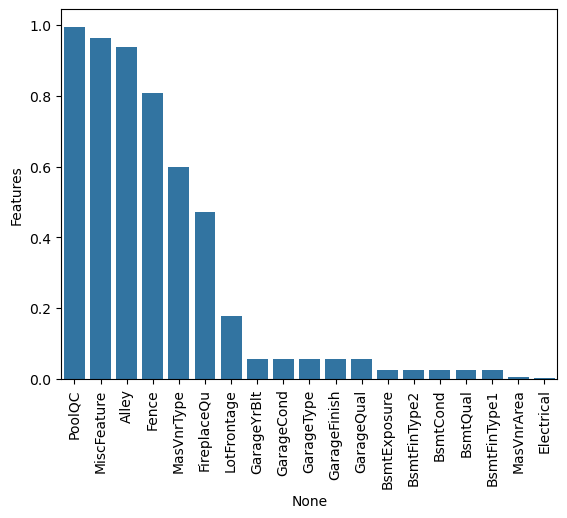

In [17]:
na_df = pd.DataFrame({"Features": train.isnull().sum(axis=0)/len(train)}
                     ).sort_values(by = 'Features', ascending=False)
na_df = na_df.loc[na_df['Features'] != 0]
print(na_df)
plt.xticks(rotation='vertical')
sns.barplot(x = na_df.index, y = na_df.Features)

# Data cleaning

In [18]:
"""
In the data_visualisation.ipynb file, we defined useless features:

1)No Correlation with SalePrice: 'YrSold', 'MoSold'

2)Quasi-constant Categorical: 'Street', 
    'Utilities', 'Condition2', 'RoofMatl', 'Heating'

3)Quasi-constant Numerical: 'LowQualFinSF', 
    'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal'
"""

# Removing useless features
train = train.drop(
    [
        "MoSold",
        "Street",
        "Utilities",
        "Condition2",
        "RoofMatl",
        "Heating",
        "LowQualFinSF",
        "KitchenAbvGr",
        "MiscVal",
        "PoolArea",
    ],
    axis=1,
)
test = test.drop(
    [
        "MoSold",
        "Street",
        "Utilities",
        "Condition2",
        "RoofMatl",
        "Heating",
        "LowQualFinSF",
        "KitchenAbvGr",
        "MiscVal",
        "PoolArea",
    ],
    axis=1,
)

# Keep'YrSold' for time being as may be useful in feature engineering.

In [19]:
train.shape

(1460, 70)

#### I wrote one part which remove outliers below, so we dont need to care here

In [20]:

# # Removing outliers
# """We use IQR"""
# """Calculate the upper and lower limits"""
# worst_outliers = ['LotFrontage','LotArea','BsmtFinSF1', 
#                   'TotalBsmtSF', 'GrLivArea']

# Q1 = train[worst_outliers].quantile(0.25)
# Q3 = train[worst_outliers].quantile(0.75)

# IQR = Q3 - Q1
# lower = Q1 - 10 * IQR
# upper = Q3 + 10 * IQR


# upper_index = np.unique(np.where(train[worst_outliers] >= upper)[0])
# lower_index = np.unique(np.where(train[worst_outliers] <= lower)[0])

# train = train.drop(index = upper_index)
# train = train.drop(index = lower_index)
# y = y.drop(index = upper_index)
# y = y.drop(index = lower_index)



In [21]:
train.shape

(1460, 70)

In [22]:
# Filling NA values
"""Firstly, we combine train and test data again to account 
for the outliers we removed"""

X = pd.concat([train, test])

na_df = pd.DataFrame({"Features": X.isnull().sum(axis=0) / len(X)}).sort_values(
    by="Features", ascending=False
)
na_df = na_df.loc[na_df["Features"] != 0]

none_cols = [
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "GarageType",
    "BsmtCond",
    "BsmtExposure",
    "BsmtQual",
    "BsmtFinType2",
    "BsmtFinType1",
    "MasVnrType",
    'PoolQC','MiscFeature','Alley','Fence','FireplaceQu'
]

for col in none_cols:
    X[col] = X[col].fillna("None")

zero_cols = [
    "MasVnrArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GarageYrBlt",
    "GarageCars",
    "TotalBsmtSF",
    "BsmtUnfSF",
    "GarageArea",
]
for col in zero_cols:
    X[col] = X[col].fillna(0)


mode_cols = ["KitchenQual", "Electrical", "SaleType", 
             "Exterior1st", "Exterior2nd"]
for col in mode_cols:
    X[col] = X.groupby("Neighborhood")[col].transform(lambda x: x.fillna(x.mode()[0]))

X["MSZoning"] = X.groupby("MSSubClass")["MSZoning"].transform(
    lambda x: x.fillna(x.mode()[0])
)

X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

X["Functional"] = X["Functional"].fillna("Typ")

In [23]:
# Mapping Categorical Features
X["CentralAir"] = X["CentralAir"].map({"N": 0, "Y": 1})
X["LotShape"] = X["LotShape"].map({"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4})
X["LandSlope"] = X["LandSlope"].map({"Gtl": 1, "Mod": 2, "Sev": 3})
QualCondMap = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}
for col in [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "GarageQual",
    "GarageCond",
    "KitchenQual",
    "HeatingQC",
    "FireplaceQu",
    "PoolQC",
]:
    X[col] = X[col].map(QualCondMap)
X["BsmtExposure"] = X["BsmtExposure"].map(
    {"None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
)
X["GarageFinish"] = X["GarageFinish"].map({"None": 0, "Unf": 1, "RFn": 2, "Fin": 3})
X["PavedDrive"] = X["PavedDrive"].map({"N": 1, "P": 2, "Y": 3})
X["Fence"] = X["Fence"].map({"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "None": 0})
# X['BsmtFinType1'] = X['BsmtFinType1'].map({'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
# X['BsmtFinType2'] = X['BsmtFinType2'].map({'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})



# Feature engineering

In [24]:
"""Add some new features representing totals and presence"""

X["TotalLot"] = X["LotFrontage"] + X["LotArea"]
X["TotalBsmtFin"] = X["BsmtFinSF1"] + X["BsmtFinSF2"]
X["TotalSF"] = (
    X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
)  # Got rid of 1stFlrSF ealier so this is new total
X["TotalSFinclGarage"] = (
    X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
)
X["TotalBath"] = (
    X["FullBath"]
    + (0.5 * X["HalfBath"])
    + X["BsmtFullBath"]
    + (0.5 * X["BsmtHalfBath"])
)
X["TotalPorch"] = (
    X["OpenPorchSF"] + X["EnclosedPorch"] + X["ScreenPorch"] + X["3SsnPorch"]
)
X["OverallQxOverallC"] = (
    X["OverallCond"] * X["OverallQual"]
)  # Multiplying together gives better score
X["ExtQxOverallQ"] = (
    X["OverallQual"] * X["ExterQual"]
)  # Multiplying together gives better score
X["RemodYrBuilt"] = X["YearRemodAdd"] - X["YearBuilt"]
X["YrsSinceRemod"] = X["YrSold"] - X["YearRemodAdd"]
X = X.drop("YrSold", axis=1)

X["HasPool"] = X["PoolQC"].apply(lambda x: 1 if x > 0 else 0)
X["HasPorch"] = X["TotalPorch"].apply(lambda x: 1 if x > 0 else 0)
X["HasBsmt"] = X["TotalBsmtFin"].apply(lambda x: 1 if x > 0 else 0)
X["HasGarage"] = X["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
X["HasFireplace"] = X["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)
X["Has2ndFloor"] = X["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
X["HasWoodDeck"] = X["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
X["HasMasVnr"] = X["MasVnrArea"].apply(lambda x: 1 if x > 0 else 0)
X["HasAlley"] = X["Alley"].apply(lambda x: 0 if x == "None" else 1)
X["Has3SsnPorch"] = X["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0)
X["HasScreenPorch"] = X["ScreenPorch"].apply(lambda x: 1 if x > 0 else 0)
# X['HasEnclosedPorch'] = X['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
# X = X.drop('PoolQC',axis = 1)

X["SimplMSZoning"] = X.MSZoning.map({"C (all)": 1, "RH": 2, "RM": 2, "RL": 3, "FV": 4})
X["GarageCarsxArea"] = X["GarageCars"] * X["GarageArea"]
X["TotalSFxOverallQual"] = X["TotalSF"] * X["OverallQual"]  # Very Good Feature
X["GrLivAreaxOverallQual"] = X["GrLivArea"] * X["OverallQual"]  # Very Good Feature
X["SimplMSZoningxTotalSF"] = X["SimplMSZoning"] * X["TotalSF"]  # Very Good Feature
X["SimplMSZoning+OverallQual"] = (
    X["SimplMSZoning"] + X["OverallQual"]
)  # Very Good Feature
X["SimplMSZoning+YearBuilt"] = X["SimplMSZoning"] + X["YearBuilt"]  # Very Good Feature
X["LotAreaxOverallQual"] = X["LotArea"] * X["OverallQual"]  # Could be worth adding
# X['KitchenQualxOverallQxOverallC'] = X['KitchenQual'] * X['OverallQxOverallC']

numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
numerical_cols.remove("train_test")
correlation = pd.concat([X[numerical_cols], y], axis=1).corr()
correlation = abs(correlation[["SalePrice"]]).sort_values(
    ["SalePrice"], ascending=False
)
print(correlation)

correlation = correlation.index.tolist()
print(correlation[1:11])

# Polynomial features of the best 10
cols = correlation[1:11]

for col in cols:
    X[col + "-2"] = X.loc[:, col] ** 2
    X[col + "-3"] = X.loc[:, col] ** 3
    X[col + "-sqrt"] = np.sqrt(np.absolute(X.loc[:, col]))


                           SalePrice
SalePrice                   1.000000
TotalSFxOverallQual         0.856148
GrLivAreaxOverallQual       0.832057
ExtQxOverallQ               0.810724
TotalSFinclGarage           0.809561
OverallQual                 0.790982
SimplMSZoningxTotalSF       0.788094
SimplMSZoning+OverallQual   0.784775
TotalSF                     0.782260
GrLivArea                   0.708624
ExterQual                   0.682639
GarageCarsxArea             0.680058
KitchenQual                 0.659600
GarageCars                  0.640409
TotalBath                   0.631731
GarageArea                  0.623431
TotalBsmtSF                 0.613581
1stFlrSF                    0.605852
BsmtQual                    0.585207
OverallQxOverallC           0.565294
FullBath                    0.560664
GarageFinish                0.549247
TotRmsAbvGrd                0.533723
SimplMSZoning+YearBuilt     0.523911
YearBuilt                   0.522897
FireplaceQu                 0.520438
Y

#### Fix Skewage in Features

In [25]:
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
numerical_cols.remove('train_test')


In [26]:
skew_features = X[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[abs(skew_features) > 0.5]
print("There are {} numerical features with abs Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
print(skewness)

There are 83 numerical features with abs Skew > 0.5 :
                                  Skew
TotalSFxOverallQual-3        29.400154
TotalSF-3                    24.199080
SimplMSZoningxTotalSF-3      22.428945
TotalSFinclGarage-3          21.610472
PoolQC                       18.409137
GrLivAreaxOverallQual-3      18.031733
HasPool                      16.997160
LotArea                      12.822431
TotalLot                     12.792022
TotalSFxOverallQual-2        12.014466
3SsnPorch                    11.376065
LotAreaxOverallQual          11.265252
GrLivArea-3                  10.436192
Has3SsnPorch                  8.712332
TotalSF-2                     8.007881
GrLivAreaxOverallQual-2       7.420619
SimplMSZoningxTotalSF-2       6.582572
TotalSFinclGarage-2           6.568014
LandSlope                     4.975157
BsmtFinSF2                    4.146143
EnclosedPorch                 4.003891
GrLivArea-2                   3.956476
ScreenPorch                   3.946694
BsmtHalfBa

In [27]:
pt = PowerTransformer()
X[high_skew.index] = pt.fit_transform(X[high_skew.index])

skew_features = X[numerical_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[abs(skew_features) > 0.5]
print("There are {} numerical features with abs Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
print(skewness)

There are 24 numerical features with abs Skew > 0.5 :
                     Skew
HasPool         16.997160
PoolQC          16.997160
Has3SsnPorch     8.712332
3SsnPorch        8.712332
LandSlope        4.213417
BsmtHalfBath     3.707260
HasAlley         3.437323
ScreenPorch      2.915215
HasScreenPorch   2.915215
BsmtFinSF2       2.355271
EnclosedPorch    1.883152
Fence            1.535352
GarageCond       1.518568
GarageQual       1.075868
BsmtCond         0.640275
RemodYrBuilt     0.587907
HalfBath         0.533886
LotShape        -0.597109
HasBsmt         -0.778641
HasPorch        -0.877684
PavedDrive      -2.757811
CentralAir      -3.459022
GarageYrBlt     -3.815869
HasGarage       -3.941054


#### Check numerical data used in training

In [28]:
def plot_num_final(show):
    if(show==True):
        numerical_cols = X.select_dtypes(exclude=['object']).columns
        fig = plt.figure(figsize = (20,100))
        ax = []
        for i,val in enumerate(numerical_cols):
            ax.append(fig.add_subplot(25,5,i+1))
            ax.append(sns.regplot(x=val,y='SalePrice', data = pd.concat(
            [X.loc[X.train_test==1],y],axis=1)))
        plt.show()
        fig.tight_layout()
plot_num_final(show)

In [29]:
X.shape

(2919, 128)

In [30]:
# Convert rest of Categorical Features using dummies
X = pd.get_dummies(X)

In [31]:
X.shape

(2919, 286)

**Have a final look at which features have the strongest correlation with SalePrice**

In [32]:
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
numerical_cols.remove('train_test')
correlation = pd.concat([X[numerical_cols],y],axis = 1).corr()
correlation = abs(correlation[['SalePrice']]).sort_values(['SalePrice'], ascending=False)
print(correlation)

                                SalePrice
SalePrice                        1.000000
TotalSFxOverallQual-2            0.847398
TotalSFxOverallQual-3            0.847398
TotalSFxOverallQual              0.847396
TotalSFxOverallQual-sqrt         0.847345
GrLivAreaxOverallQual-2          0.809843
GrLivAreaxOverallQual-3          0.809843
GrLivAreaxOverallQual            0.809840
GrLivAreaxOverallQual-sqrt       0.809784
TotalSFinclGarage-sqrt           0.808397
TotalSFinclGarage                0.799357
TotalSFinclGarage-2              0.799357
TotalSFinclGarage-3              0.799357
OverallQual                      0.790982
TotalSF-sqrt                     0.785611
SimplMSZoning+OverallQual        0.784775
SimplMSZoning+OverallQual-3      0.783775
SimplMSZoning+OverallQual-2      0.783725
OverallQual-3                    0.781728
OverallQual-2                    0.781518
SimplMSZoningxTotalSF            0.779025
SimplMSZoningxTotalSF-2          0.779025
SimplMSZoningxTotalSF-3          0

# Modeling


#### Write Learning Curve and Validation Curve function to determine whether model is good fit

In [33]:
def plot_learning_curve(estimator, X, y, cv, train_sizes):
    plt.figure()
    plt.title(str(estimator))
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs = -1, 
                                                            train_sizes=train_sizes, scoring = 'neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r',
             label = 'Training score')

    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g',
             label = 'Cross-validation score')
    plt.legend(loc = 'best')
    return plt    

In [34]:
def plot_validation_curve(model, X, y, param_name, param_range, cv):
    train_score, test_score = validation_curve(model, X, y, 
                                               param_name=param_name,
                                               param_range=param_range,
                                               cv = cv, 
                                               scoring = 'neg_mean_squared_error')
    train_score_mean = np.mean(train_score, axis = 1)
    test_score_mean = np.mean(test_score, axis = 1)
    
    train_score_std = np.std(train_score, axis = 1)
    test_score_std = np.std(test_score, axis = 1)
    
    plt.plot(param_range, train_score_mean, label = "Training Score",
             color = 'darkblue')
    plt.fill_between(param_range, train_score_mean - train_score_std, 
                     train_score_mean + train_score_std, color = 'lightgreen')
    
    plt.plot(param_range, test_score_mean, label = "Training Score",
             color = 'darkblue')
    plt.fill_between(param_range, test_score_mean - test_score_std, 
                     test_score_mean + test_score_std, color = 'lightgreen')
    
    plt.title(str(model))
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.legend(loc = 'best')

#### Split back into Train and Test dataset

In [35]:
X_train = X[X.train_test == 1].drop(['train_test'], axis=1)
X_test = X[X.train_test == 0].drop(['train_test'], axis=1)

In [36]:
X_train.shape

(1460, 285)

In [37]:
X_train.head()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,TotalLot,TotalBsmtFin,TotalSF,TotalSFinclGarage,TotalBath,TotalPorch,OverallQxOverallC,ExtQxOverallQ,RemodYrBuilt,YrsSinceRemod,HasPool,HasPorch,HasBsmt,HasGarage,HasFireplace,Has2ndFloor,HasWoodDeck,HasMasVnr,HasAlley,Has3SsnPorch,HasScreenPorch,SimplMSZoning,GarageCarsxArea,TotalSFxOverallQual,GrLivAreaxOverallQual,SimplMSZoningxTotalSF,SimplMSZoning+OverallQual,SimplMSZoning+YearBuilt,LotAreaxOverallQual,TotalSFxOverallQual-2,TotalSFxOverallQual-3,TotalSFxOverallQual-sqrt,GrLivAreaxOverallQual-2,GrLivAreaxOverallQual-3,GrLivAreaxOverallQual-sqrt,ExtQxOverallQ-2,ExtQxOverallQ-3,ExtQxOverallQ-sqrt,TotalSFinclGarage-2,TotalSFinclGarage-3,TotalSFinclGarage-sqrt,OverallQual-2,OverallQual-3,OverallQual-sqrt,SimplMSZoningxTotalSF-2,SimplMSZoningxTotalSF-3,SimplMSZoningxTotalSF-sqrt,SimplMSZoning+OverallQual-2,SimplMSZoning+OverallQual-3,SimplMSZoning+OverallQual-sqrt,TotalSF-2,TotalSF-3,TotalSF-sqrt,GrLivArea-2,GrLivArea-3,GrLivArea-sqrt,ExterQual-2,ExterQual-3,ExterQual-sqrt,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrica

In [38]:
X_test.shape

(1459, 285)

In [39]:
X_test.head()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,TotalLot,TotalBsmtFin,TotalSF,TotalSFinclGarage,TotalBath,TotalPorch,OverallQxOverallC,ExtQxOverallQ,RemodYrBuilt,YrsSinceRemod,HasPool,HasPorch,HasBsmt,HasGarage,HasFireplace,Has2ndFloor,HasWoodDeck,HasMasVnr,HasAlley,Has3SsnPorch,HasScreenPorch,SimplMSZoning,GarageCarsxArea,TotalSFxOverallQual,GrLivAreaxOverallQual,SimplMSZoningxTotalSF,SimplMSZoning+OverallQual,SimplMSZoning+YearBuilt,LotAreaxOverallQual,TotalSFxOverallQual-2,TotalSFxOverallQual-3,TotalSFxOverallQual-sqrt,GrLivAreaxOverallQual-2,GrLivAreaxOverallQual-3,GrLivAreaxOverallQual-sqrt,ExtQxOverallQ-2,ExtQxOverallQ-3,ExtQxOverallQ-sqrt,TotalSFinclGarage-2,TotalSFinclGarage-3,TotalSFinclGarage-sqrt,OverallQual-2,OverallQual-3,OverallQual-sqrt,SimplMSZoningxTotalSF-2,SimplMSZoningxTotalSF-3,SimplMSZoningxTotalSF-sqrt,SimplMSZoning+OverallQual-2,SimplMSZoning+OverallQual-3,SimplMSZoning+OverallQual-sqrt,TotalSF-2,TotalSF-3,TotalSF-sqrt,GrLivArea-2,GrLivArea-3,GrLivArea-sqrt,ExterQual-2,ExterQual-3,ExterQual-sqrt,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrica

#### Apply log transformation on SalePrice to reduce the skewage

<Axes: xlabel='SalePrice', ylabel='Count'>

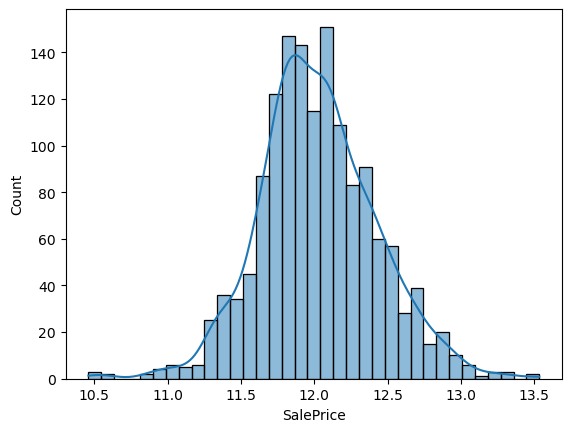

In [40]:
y = np.log(y)
sns.histplot(y, kde = True)

#### Removing train constant and quasi-constant columns which may overfit the data. MSZoning_C is example of this, it is over 99% 0s but has very large coefficients in my model

#### Over 99.94% Corresponds to Constant. Over 99.93% Corresponds to all constant but 1. Over 99.86% corresponds to all constant but 2. Over 99.79% corresponds to all constant but 3. And so on...

In [41]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) > 0.9994:
        overfit.append(i)
overfit.append("MSZoning_C (all)") # Largest coefficients in Regularization models but mostly 0
print(overfit)

['MSSubClass_150', 'MSZoning_C (all)']


In [42]:
X_train = X_train.drop(overfit, axis = 1)
X_test = X_test.drop(overfit, axis = 1)

#### Try applying PCA as we have a large number of correlated features. This didn't improve results so I have not used it

In [43]:
# from sklearn.decomposition import PCA
# print(len(X_train.columns))

# pca = PCA()

# train_index = X_train.index
# test_index = X_test.index

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)


# component_names = [f"PC{i+1}" for i in range(X_train.shape[1])]

# X_train = pd.DataFrame(X_train, columns=component_names, index = X_train.index)

# component_names = [f"PC{i+1}" for i in range(X_test.shape[1])]

# X_test = pd.DataFrame(X_test, columns=component_names, index = X_test.index)


#### Finally, remove outliers which were found to have a negative impact on the regression. I will only remove the very worst outliers which sigma >=4 to start with. Removing outliers with sigma >= 3 made results worse on LB but I will try remove outliers shared between models at this sigma at a later stage

In [44]:
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff ** 2)
    
    return np.sqrt(sum_sq / len(y_pred))

# RMSE(sigma^) = sqrt(MSE(sigma^)) = sqrt(E[(sigma^ - sigma)^2])

In [45]:
def find_outliers(model, X_train, y, sigma):
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X_train), index = y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X_train, y)
        y_pred = pd.Series(model.predict(X_train), index = y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = np.mean(resid)
    std_resid = np.std(resid)
    
    # calculate z statistics, define outliers to be where |z| > sigma
    z = (resid - mean_resid) / std_resid
    
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print(str(model))
    print('R2=',model.score(X_train,y))
    print('rmse=',rmse(y, y_pred))
    print('mean of residuals:',resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())
    print('---------------------------------------')
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title(str(model))
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title(str(model))
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    plt.title(str(model))
    
    return outliers.tolist()
    

#### After seeing the scores without removing outliers, I'll use ridgeCV as the meta-model when stacking so use this model as a basis for the outliers

RidgeCV()
R2= 0.9298631114739326
rmse= 0.10575208106466866
mean of residuals: Id
1       0.006342
2      -0.097942
3       0.036059
4      -0.202530
5      -0.185141
6      -0.104118
7       0.102254
8      -0.080931
9       0.013848
10     -0.094866
11     -0.004231
12     -0.060746
13      0.093463
14      0.223497
15     -0.013602
16     -0.048112
17     -0.063147
18     -0.230352
19      0.019814
20      0.132262
21     -0.020243
22      0.089511
23     -0.016602
24     -0.065745
25      0.003691
26     -0.012675
27      0.034713
28      0.034924
29      0.055076
30      0.078427
31     -0.546422
32      0.081522
33     -0.107096
34     -0.092432
35     -0.038381
36     -0.043946
37     -0.022742
38      0.003295
39     -0.148629
40      0.065732
41      0.088707
42      0.018143
43     -0.066711
44     -0.009841
45     -0.022981
46      0.095019
47     -0.089618
48     -0.021886
49      0.131215
50     -0.025537
51     -0.011481
52     -0.077696
53      0.178143
54      0.139645
5

ElasticNetCV()
R2= 0.8325124881757867
rmse= 0.16342063367367574
mean of residuals: Id
1       0.104952
2      -0.051706
3       0.102416
4      -0.233657
5      -0.049554
6      -0.022919
7       0.195048
8      -0.043390
9      -0.042672
10     -0.018712
11      0.025656
12      0.197331
13      0.175997
14      0.151720
15      0.077402
16     -0.178882
17     -0.039828
18     -0.119537
19     -0.001715
20      0.011404
21      0.135899
22      0.169835
23     -0.083241
24     -0.034737
25     -0.039999
26     -0.032685
27     -0.126433
28      0.136458
29      0.098209
30     -0.063791
31     -0.573887
32     -0.063740
33     -0.055491
34      0.003169
35      0.130780
36      0.139554
37     -0.088267
38     -0.121721
39     -0.326917
40      0.069593
41      0.058149
42      0.118534
43      0.032255
44      0.019752
45      0.050076
46      0.194939
47     -0.053418
48     -0.215119
49      0.080730
50     -0.049094
51      0.080265
52      0.030420
53      0.096829
54      0.272

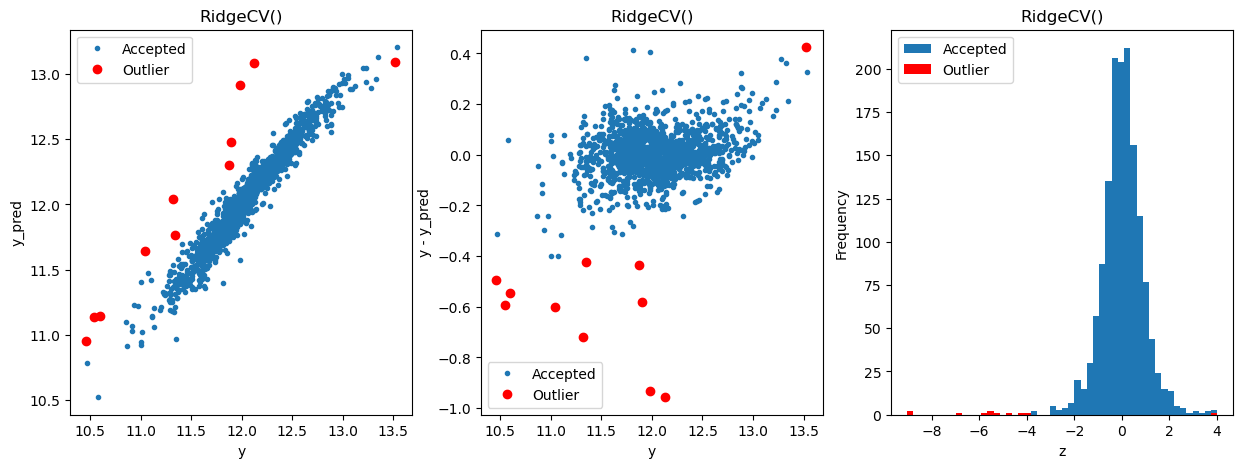

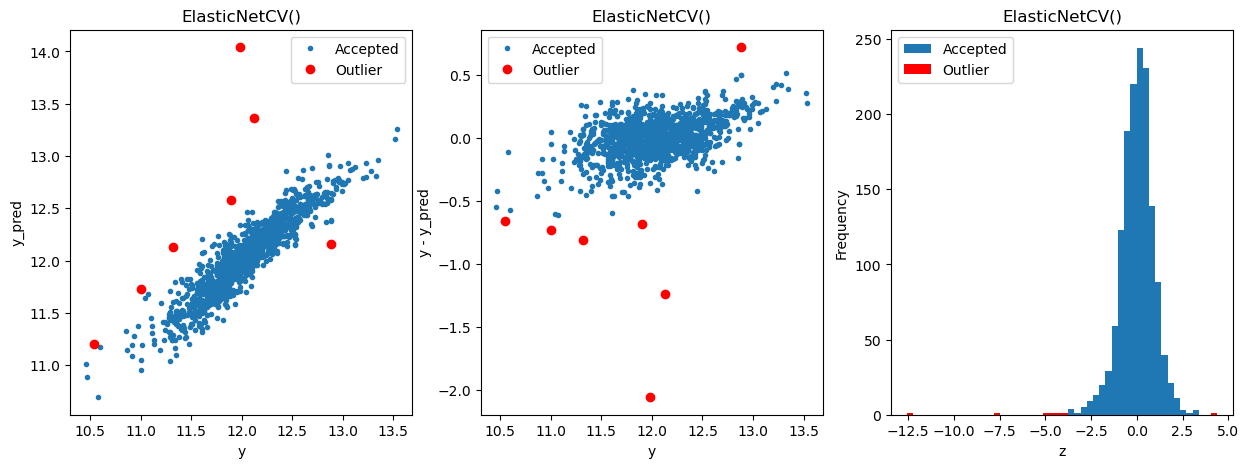

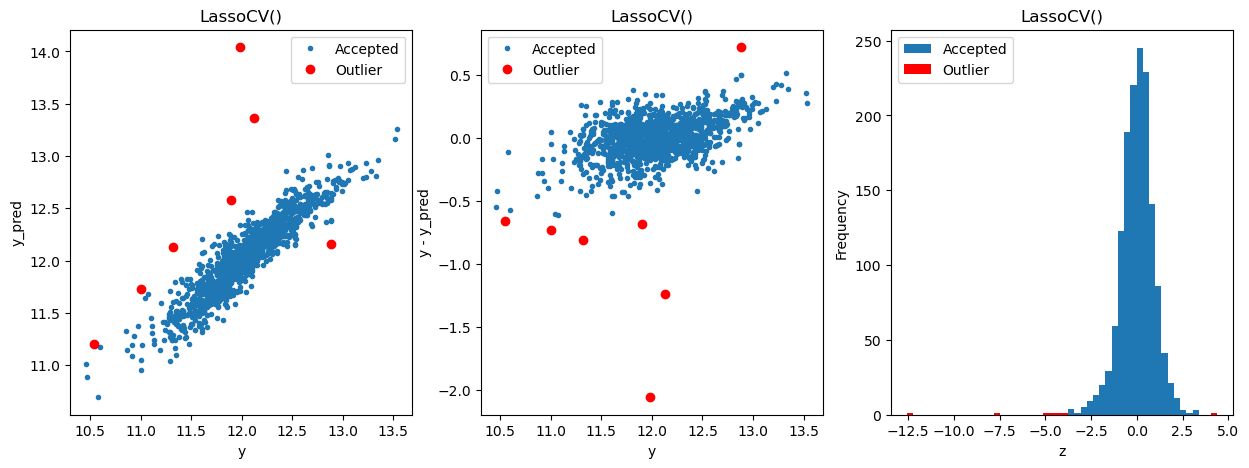

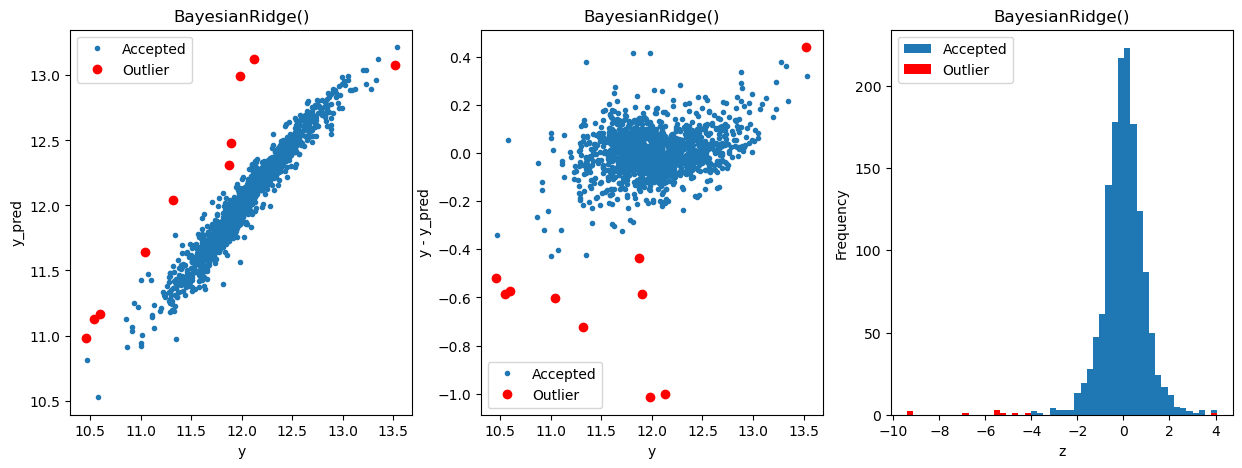

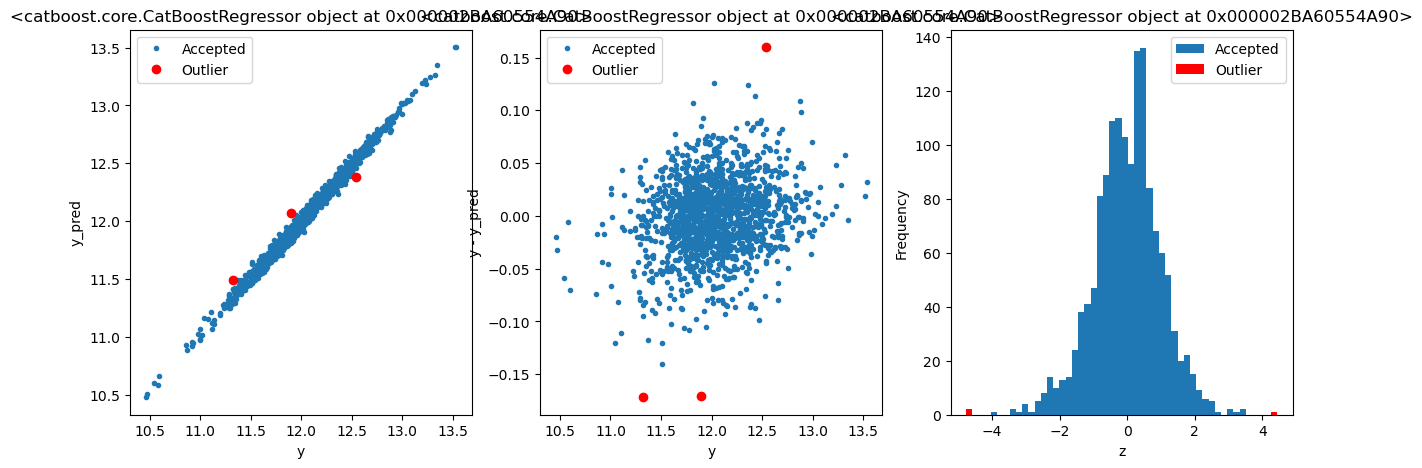

In [46]:
ridge_outliers = find_outliers(RidgeCV(), X_train, y, 4)
elastic_outliers = find_outliers(ElasticNetCV(), X_train, y, 4)
lasso_outliers = find_outliers(LassoCV(), X_train, y, 4)
bayridge_outliers = find_outliers(linear_model.BayesianRidge(), X_train, y, 4)
cbr_outliers = find_outliers(CatBoostRegressor(logging_level='Silent', 
                                               loss_function="RMSE"), X_train, y, sigma = 4)

outliers4 = ridge_outliers
outliers4.extend(elastic_outliers)
outliers4.extend(lasso_outliers)
outliers4.extend(bayridge_outliers)
outliers4.extend(cbr_outliers)

print(outliers4)
outliers4_count = pd.Series(outliers4).value_counts()
print(outliers4_count)
print(f"Number of shared outliers: {len(outliers4_count)}")

#### You can look at outliers 3 sigma+ out if you want

#### Dropping the very worst outliers which is over 4 sigma here

In [47]:
X_train = X_train.drop(outliers4_count.index)
y = y.drop(outliers4_count.index)

#### Test a number of regression models using 5 fold cross validation and score using the same scoring system as in the leaderboards

In [48]:
X_train.shape

(1446, 283)

In [49]:
X_test.shape

(1459, 283)

In [57]:
scores = {}
kf = KFold(10, shuffle=True, random_state=0)

lasso = Pipeline([('scaler', RobustScaler()), ('lasso', LassoCV(n_jobs=-1))])

elastic = Pipeline([('scaler', RobustScaler()), ('elastic', LassoCV(n_jobs=-1))])

xgb = XGBRegressor(random_state=0, n_jobs=-1)

lgbm = LGBMRegressor(n_jobs=-1)

rf = RandomForestRegressor(n_jobs=-1)

# no n_jobs
cbr = CatBoostRegressor(logging_level='Silent', loss_function='RMSE')
linsvr = Pipeline([('scaler', RobustScaler()), ('svr', LinearSVR(random_state=0))])
ridge = Pipeline([('scaler', RobustScaler()), ('ridge', RidgeCV())])
bayridge = Pipeline([('scaler', RobustScaler()), ('bayridge', linear_model.BayesianRidge())])
gbr = GradientBoostingRegressor(random_state=0)

def models_cv(list_regression, list_name, X, y, kf, scores):
    for name, regression in zip(list_name, list_regression):
        cv = np.sqrt(-cross_val_score(regression, X, y, cv=kf, 
                            n_jobs=-1, scoring='neg_mean_squared_error'))
        scores[name] = cv.mean()
    return pd.Series(scores).sort_values(ascending=True)
        
list_regression = [lasso, elastic, xgb, lgbm, rf, cbr, linsvr, 
           ridge, bayridge, gbr]
list_name_regression = ['lasso', 'elastic', 'xgb', 
                        'lgbm', 'rf', 'cbr', 
                        'linsvr', 'ridge', 'bayridge', 'gbr']

score_models = models_cv(list_regression=list_regression, list_name=list_name_regression
                         , X=X_train, y=y, kf=kf, scores=scores)
print(score_models)

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

#### Hypeparameter Tuning

In [61]:
best_score_regression = [regression.fit(X_train, y) for regression in list_regression]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11019
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 220
[LightGBM] [Info] Start training from score 12.027653
[Pipeline(steps=[('scaler', RobustScaler()), ('lasso', LassoCV(n_jobs=-1))]), Pipeline(steps=[('scaler', RobustScaler()), ('elastic', LassoCV(n_jobs=-1))]), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
   

#### Plot Learning Curves to see overfitting/underfitting. I will only use this on lgbm, gbr and cbr when I start tuning parameters as using the cross validation on the regularization models it becomes very easy to see when they are fit well

In [52]:
kfold = 3
def plots_learning_curve(show, list_regression, X, y, kfold):
    if show == True:
        for regression in list_regression:
            plot_learning_curve(regression,X,y,kfold,np.linspace(0.1,1,10))
    
plots_learning_curve(show, list_regression = best_score_regression, 
                     X = X_train, y = y, kfold=kfold)


*All models are showing signs of a good fit, with a converging training and cross-validation score over training examples. The only model showing otherwise, as overfitting, is cbr. However, the training score is converging so the overfitting isn't severe enough to disregard the model*

**Look at feature importances and coefficients for the regularization models. This can give insight into new features we can make alongside the correlations with SalePrice**

In [54]:
def regression_coeff(show, list_regression, X):
    if show == True:
        for reg in list_regression:
            reg_coeff = pd.DataFrame({'Lasso Feature Importance':abs(reg.steps[1][1].coef_)}, index=X.columns)
            reg_coeff[reg_coeff["Lasso Feature Importance"]!=0].sort_values("Lasso Feature Importance").plot(kind="barh",figsize=(15,25))
            plt.xticks(rotation=90)
regression_coeff(show, list_regression=best_score_regression, X = X_train)

**Look at correlations of models before deciding on blending. If the results of models are very highly correlated we should consider this in our ensembling to avoid bias.**

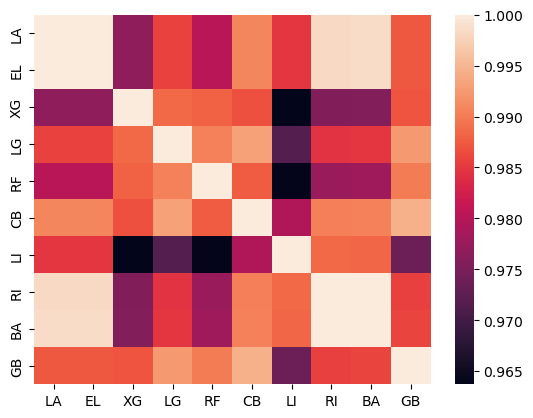

In [64]:
def regression_predictions(show, list_regression, list_name, X_test):
    predictions = {}
    list_predict = []
    for reg, name_reg in zip(list_regression, list_name):
        predictions[name_reg] = reg.predict(X_test)
        list_predict.append(pd.Series(reg.predict(X_test), name=name_reg[:2].upper()))
        
    model_predictions = pd.concat(list_predict, axis = 1)
    if show == True:
        sns.heatmap(model_predictions.corr())
    return predictions
        
list_predictions = regression_predictions(True, best_score_regression, list_name_regression, X_test=X_test)

    

In [65]:
print(list_name_regression) 

['lasso', 'elastic', 'xgb', 'lgbm', 'rf', 'cbr', 'linsvr', 'ridge', 'bayridge', 'gbr']


In [79]:
list_predictions = pd.DataFrame(list_predictions)
list_predictions.shape

(1459, 10)

In [101]:
def blended_model(list_num: list, df_predict: pd.DataFrame) -> list:
    row, col = df_predict.shape
    for num, name in zip(list_num, df_predict.columns):
        df_predict[name] = df_predict[name] * num
    return np.exp([df_predict.iloc[i].sum() for i in range(row)])

list_num = [0 for i in range(len(list_name_regression))]
# Only use XGB
list_num[3] = 1
predictions = blended_model(list_num=list_num, df_predict=list_predictions)

print(predictions)

[130651.93119173 165256.90423371 186574.14170379 ... 156232.5296104
 106041.79474942 212442.28536579]


# 8) Submission

In [102]:
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': predictions})
submission.to_csv("Imputed.csv", index=False)

# submission.to_csv("../../kaggle/working/Imputed.csv", index=False)